<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/forecasting_sorrows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Sorrows Of A Young Data Scientist



In [1]:
! pip install sktime

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from graphviz import Digraph
from IPython.display import Image
from sktime.transformations.series.detrend import Deseasonalizer

plt.rc("figure", figsize=(15, 10))

**Imagine the following scenario**:

You are supposed to **optimize the price** of some product, e.g. the margin for FX-spot.

Let us assume that your business partners would like to optimize with respect to gross income (GI), i.e. GI = volume x price. 

Of course, volume will depend on price, so we actually have that **GI(p) = v(p) x p**, where v stands for volume.    

There is some historical pricing data which can be used to construct a model, so you feel like that a reasonable way to proceed is to fit a demand model (for the volume) and then find the price which maximizes the GI (where you use the demand model as a plug-in estimator for the volume)

To put it in a nutshell, the plan goes something like this:



1.   Fit a model, s.t. volume = f(price)
2.   Then optimize GI, i.e. f(price) x price, with respect to the price
3.   Profit

In [33]:
def get_data(seed=None, price=None):
    date_idx = pd.date_range(start="2014-01-01", end="2021-02-01")
    
    if seed:
        np.random.seed(seed)
    
    days = np.arange(date_idx.shape[0])
    annual_seas_term = 2*np.pi*days/365.25

    nterms = 5
    phase = np.random.normal(size=(nterms, 1))
    amplitude = np.random.normal(size=(nterms, 1))
    
    error = np.random.normal(scale=0.25, size=(nterms, annual_seas_term.shape[0]))
    fourier_terms = (
        amplitude * np.cos(
          np.outer(np.arange(1, 1 + nterms), annual_seas_term) + phase)
    )

    capacity = 1000*np.sqrt(np.exp(np.sum(fourier_terms + error, axis=0)))

    fourier_expert = 2.*np.cos(annual_seas_term + 2) + \
      np.random.normal(scale=.15, size=days.shape[0])
    
    if price is None:
        price_fraction = 1/(1 + np.exp(-fourier_expert))
        price = 0.1 + price_fraction*2

    volume = capacity / (1 + np.exp(-2 + 3*price))
    gi = volume * price

    return pd.DataFrame({
        "price": price,
        "volume": volume,
        "gi": gi
    }, index=date_idx)


In [34]:
hist_price = get_data(seed=5)
hist_price

,price,volume,gi
2014-01-01,0.589061,1034.366066,609.305088
2014-01-02,0.839837,520.864089,437.440982
2014-01-03,0.744168,404.417257,300.954425
2014-01-04,0.659435,793.378461,523.181462
2014-01-05,0.624782,653.453814,408.265926
...,...,...,...
2021-01-28,0.475010,986.945340,468.809286
2021-01-29,0.467560,814.894248,381.012338
2021-01-30,0.436662,1388.787028,606.431043
2021-01-31,0.367882,667.587851,245.593683


In [35]:
hist_price.gi.mean()

234.57286427644584

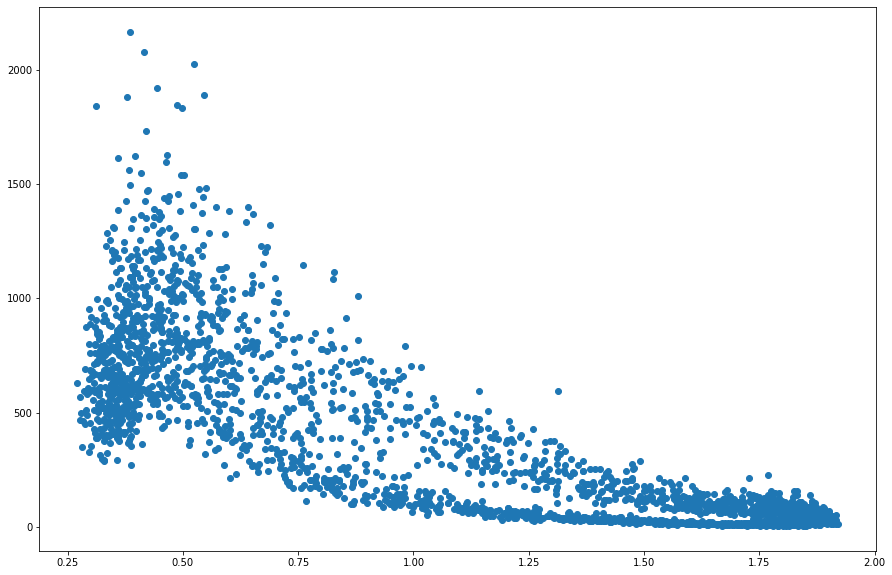

In [36]:
plt.scatter(hist_price.price, hist_price.volume)

In [37]:
print("Stationarity test for price:", sm.tsa.stattools.adfuller(hist_price.price))
print("Stationarity test for volume:", sm.tsa.stattools.adfuller(hist_price.volume))

Stationarity test for price: (-10.052420242533916, 1.401170917820094e-17, 28, 2560, {'1%': -3.4329069801374077, '5%': -2.862669671881199, '10%': -2.5673713661193847}, -7353.483423791537)
Stationarity test for volume: (-5.302587512715819, 5.408479020896298e-06, 26, 2562, {'1%': -3.432904982050806, '5%': -2.8626687895063343, '10%': -2.567370896334526}, 33329.33100879331)


While the plot looks strange, the augmented Dickey-Fuller tests would indicate that both variables are stationary, so everything fine?

Text(0, 0.5, 'Volume')

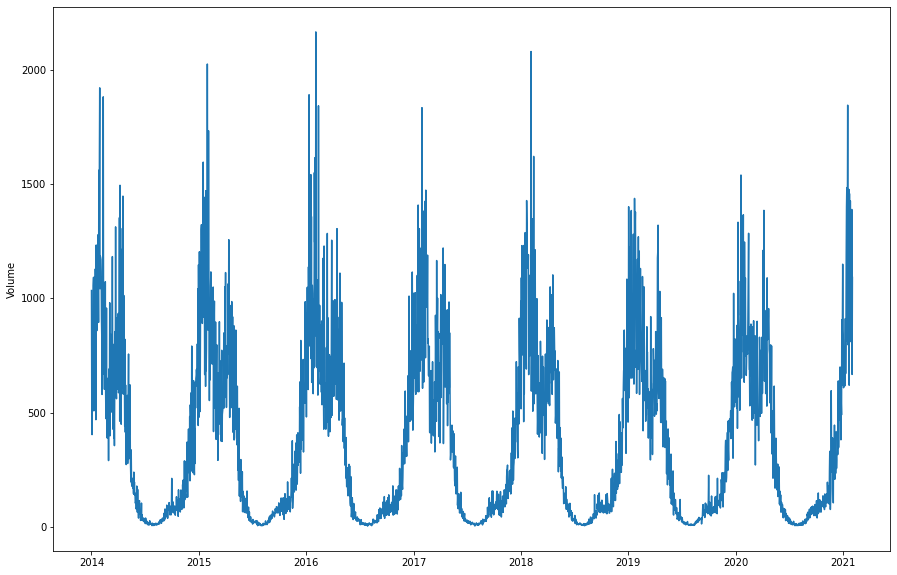

In [38]:
plt.plot(hist_price.volume)
plt.ylabel("Volume")

We can clearly see some seasonality in the plot, let's remove it by assuming that an annual seasonality is present in the data.

Text(0, 0.5, 'Seasonality-adjusted Volume')

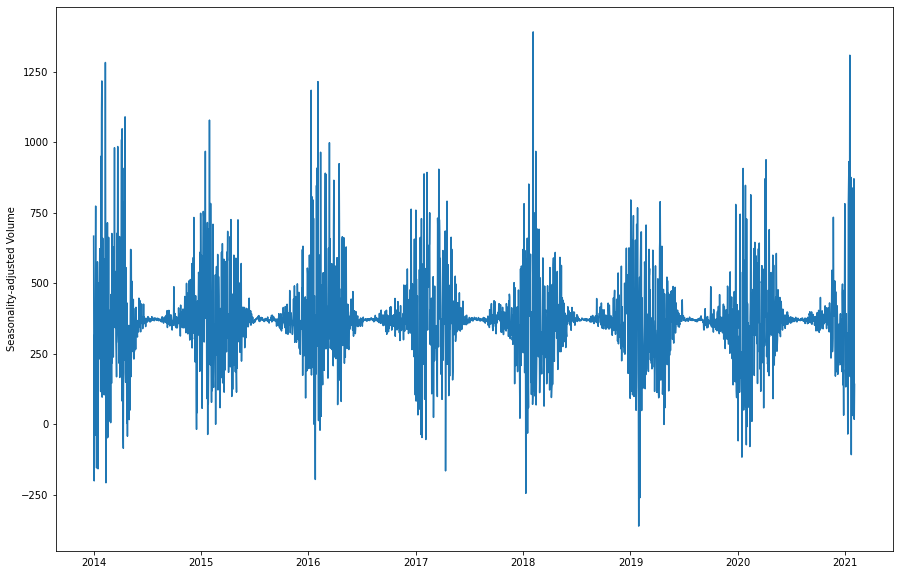

In [39]:
dseas = Deseasonalizer(sp=365)
dseas_volume = dseas.fit_transform(hist_price.volume)
plt.plot(dseas_volume)
plt.ylabel("Seasonality-adjusted Volume")

Looks better, but there is still some unaddressed, temporal component in form of the different variance blocks. Quite often such issues can be mitigated by using power transformations or simply taking the logarithm.

Text(0, 0.5, 'Seasonality-adjusted Log-Volume')

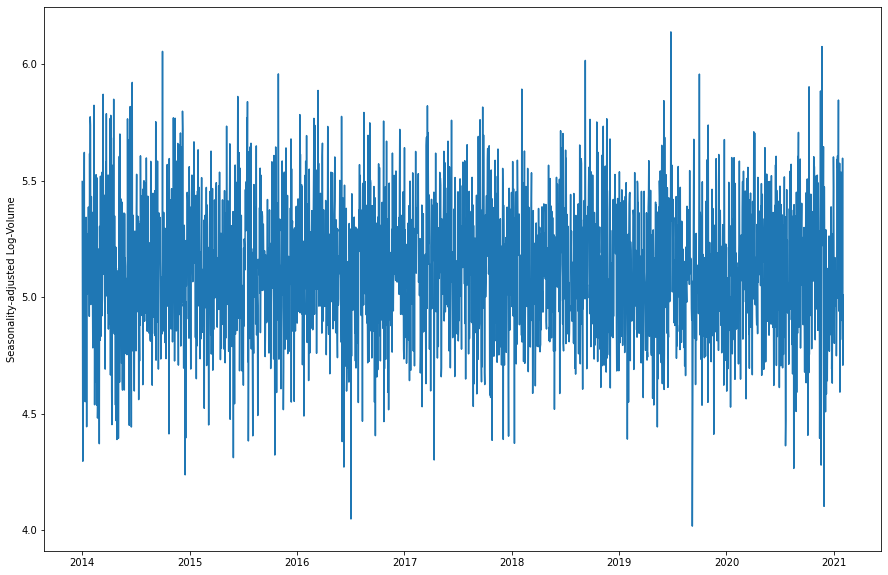

In [40]:
hist_price["log_volume"] = np.log(hist_price.volume)
hist_price["deseas_log_volume"] = dseas.fit_transform(hist_price.log_volume)
plt.plot(hist_price.deseas_log_volume)
plt.ylabel("Seasonality-adjusted Log-Volume")

Looks much nicer :-)

                            OLS Regression Results                            
Dep. Variable:      deseas_log_volume   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.769
Date:                Wed, 14 Apr 2021   Prob (F-statistic):             0.0962
Time:                        22:46:46   Log-Likelihood:                -465.29
No. Observations:                2589   AIC:                             934.6
Df Residuals:                    2587   BIC:                             946.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1409      0.012    420.653      0.0

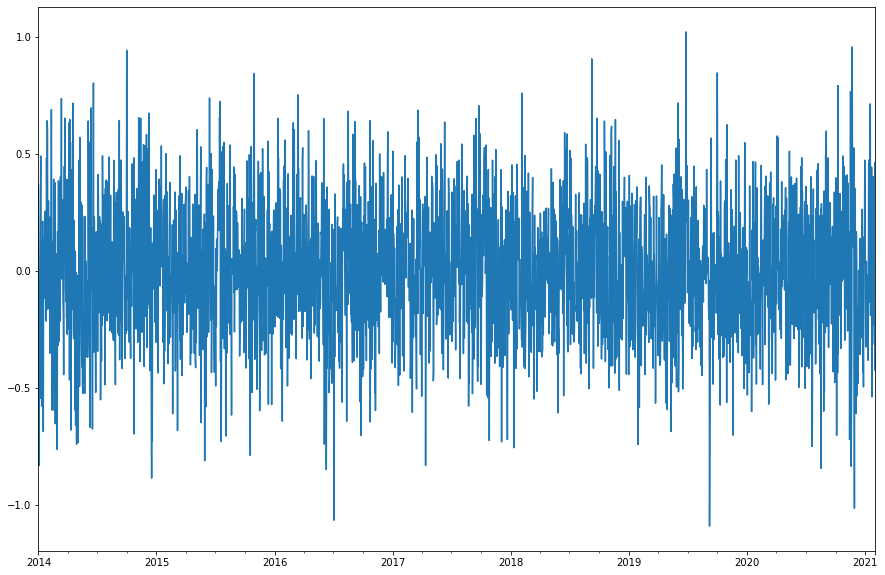

In [47]:
mdl_deseas = sm.OLS(
    hist_price.deseas_log_volume, 
    sm.add_constant(hist_price.price))
mdl_deseas = mdl_deseas.fit()
print(mdl_deseas.summary())
mdl_deseas.resid.plot()

                            OLS Regression Results                            
Dep. Variable:             log_volume   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     7823.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:51:43   Log-Likelihood:                -2884.1
No. Observations:                2589   AIC:                             5772.
Df Residuals:                    2587   BIC:                             5784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5797      0.031    243.661      0.0

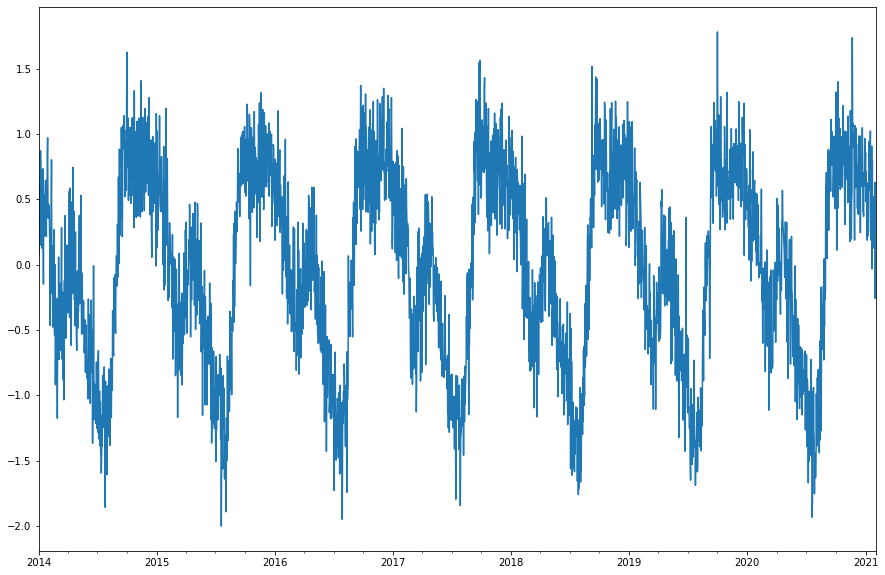

In [50]:
mdl_season = sm.OLS(hist_price.log_volume, sm.add_constant(hist_price.price))
mdl_season = mdl_season.fit()
print(mdl_season.summary())
mdl_season.resid.plot()

Seems like our seasonally-adjusted model is doing fine. Surprisingly, it would suggest that the price does not have an impact on the volume, so turn it up to the max? 

Thanks to the fact that we are using simulated data, we can simply rerun the simulation with the higher price and check how much richer we made the company :)

In [58]:
fixed_price = get_data(seed=5, price=2.1)

*drum roll*

In [62]:
print("GI for old approach: {:.2f}".format(hist_price.gi.mean()))
print("GI for new, data-driven approach: {:.2f}".format(fixed_price.gi.mean()))

GI for old approach: 234.57
GI for new, data-driven approach: 36.09


Great, we would have bankrupted the bank ... :(

What went wrong???

The issue is one of causality (as so often)

We were modelling under the assumption that the causal relationship looks a lot like this:

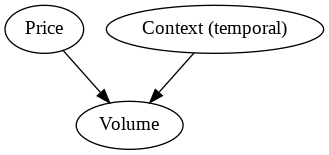

In [68]:
dot = Digraph()

dot.node("P", "Price")
dot.node("C", "Context (temporal)")
dot.node("V", "Volume")

dot.edges(["PV", "CV"])
dot.render("causal-graph1.cv", view=True, format="png")
Image('causal-graph1.cv.png')

While in reality, it was looking way more like this for the historical data:

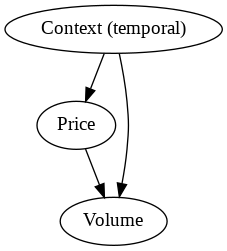

In [69]:
dot = Digraph()

dot.node("P", "Price")
dot.node("C", "Context (temporal)")
dot.node("V", "Volume")

dot.edges(["PV", "CV", "CP"])
dot.render("causal-graph2.cv", view=True, format="png")
Image('causal-graph2.cv.png')

Let's plot to see price and volume over time together.

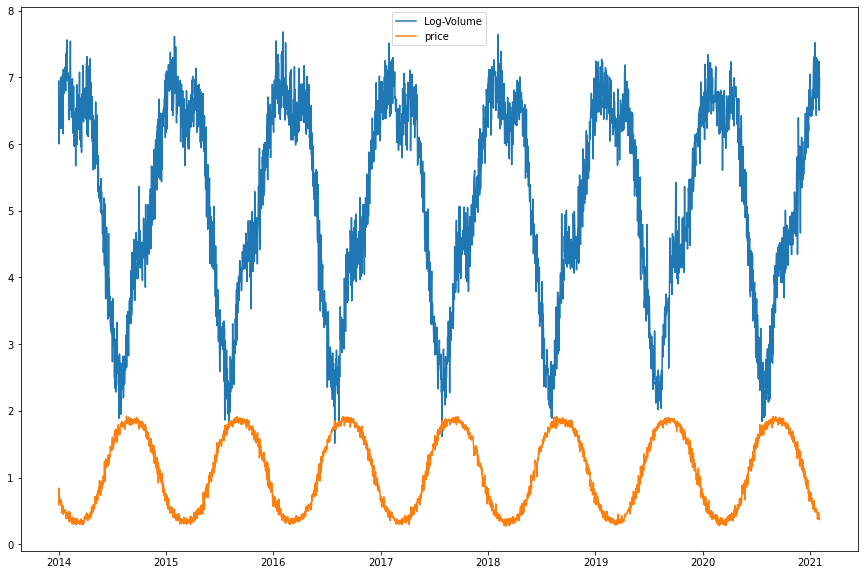

In [70]:
plt.plot(hist_price.log_volume, label="Log-Volume")
plt.plot(hist_price.price, label="price")
plt.legend(loc="best")

Clearly, the prices where not picked randomly, it seems like some strategy, where falling volumes were compensated with increasing margins and vice versa. This could have also happened in anticipation of falling/increasing volumes, so the seasonality information is somehow related with the changes in price --> it is hard to isolate whether high/low volumes are due to seasonality patterns or the prices.

Interestingly, if we were only concerned with prediction, this would have probably not consituted much of an issue, as in this case, all the predictive power seems to be already in the seasonality, so even if we had predicted out-of-sample only with the seasonality patterns, the results would have been decent. Of course, this only applies to the situation that we do not forefully change the dependence between temporal context and prices. But this is what we exactly did, by setting the prices to high in all situation, we broke the causal relationship. 

The whole situation gives rise to an important classification of data science use cases and their corresponding three questions they try to answer (based on Griffin's paper on Data Science ROI):

1. Prediction: What is happening?
2. Causal Inference: Why is it happening?
3. Control: What actions can I take?